In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def potential_LJ(r, sigma, eps):
    return 4 * eps * ((sigma / r) ** 12 - (sigma / r) ** 6)


def potential_fene_lammps(r, K, R_0, sigma, eps):
    r_LJ_min = 2 ** (1 / 6) * sigma

    return np.piecewise(
        r,
        [r <= r_LJ_min, np.logical_and(r > r_LJ_min, r <= R_0), r > R_0],
        [
            lambda r: -0.5 * K * R_0 ** 2 * np.log(1 - (r / R_0) ** 2) + potential_LJ(r, sigma, eps) + eps,
            lambda r: -0.5 * K * R_0 ** 2 * np.log(1 - (r / R_0) ** 2) + eps,
            lambda _: 0
        ]
    )


def potential_harmonic(r, K, r_0):
    return K * (r - r_0) ** 2


In [16]:
K = 30.0
R_0 = 1.5
eps = 1.0
sigma = 1

In [43]:
import scipy.optimize
from functools import partial

opt_results = scipy.optimize.minimize(
    partial(potential_fene_lammps, K=K, eps=eps, sigma=sigma, R_0=R_0),
    1,
    bounds=[(.8, R_0)],
    tol=1e-7
)
print(opt_results)

f = lambda r, K: potential_harmonic(r, K=K, r_0=opt_results["x"][0]) + opt_results["fun"]
xdata = np.linspace(.8, R_0, num=1000, endpoint=False)
ydata = potential_fene_lammps(xdata, K, R_0, sigma, eps)

harmonic_fit_results = scipy.optimize.curve_fit(f, xdata, ydata, [400.0])
K_harm = harmonic_fit_results[0][0]
K_harm

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 20.202573814938688
        x: [ 9.609e-01]
      nit: 4
      jac: [-3.283e-04]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


317.34737082828576

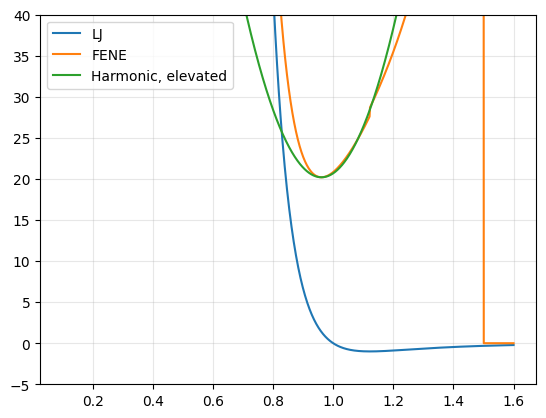

In [46]:
rs = np.linspace(.1, 1.6, 1000)

plt.plot(rs, potential_LJ(rs, sigma, eps), label="LJ")
plt.plot(rs, potential_fene_lammps(rs, K, R_0, sigma, eps), label="FENE")
plt.plot(rs, f(rs, K_harm), label="Harmonic, elevated")
plt.ylim(-5, 40)
plt.grid(alpha=0.3)
plt.legend()

In [47]:
K_harm / 2

158.67368541414288

In [40]:
f = lambda r, K: potential_harmonic(r, K=K, r_0=opt_results["x"][0]) + opt_results["fun"]
xdata = np.linspace(.8, R_0, num=1000, endpoint=False)
ydata = potential_fene_lammps(xdata, K, R_0, sigma, eps)

scipy.optimize.curve_fit(f, xdata, ydata, [400.0])

(array([317.34737083]), array([[9.93067315]]))

In [100]:
def rouse_R_sq_avg(t, p_max: int, N: int, b: float, tau_1: float):
    result = np.zeros(shape=t.shape)
    for p in range(1, p_max):
        if p % 2 == 0:
            continue
        result += 1 / p ** 2
    return 8 * N * b ** 2 / np.pi ** 2 * result


def rouse_R_autocorr(t, p_max: int, N: int, b: float, tau_1: float):
    result = 0
    for p in range(1, p_max):
        if p % 2 == 0:
            continue
        result += 1 / p ** 2 * np.exp(-t * p ** 2 / tau_1)
    return 8 * N * b ** 2 / np.pi ** 2 * result

def rouse_g_4(t, p_max: int, N: int, b: float, tau_1: float):
    result = 0
    for p in range(1, p_max + 1):
        if p % 2 == 0:
            continue
        result += 1 / p ** 2 * (1 - np.exp(-t * p ** 2 / tau_1))
    return 16 * N * b ** 2 / np.pi ** 2 * result

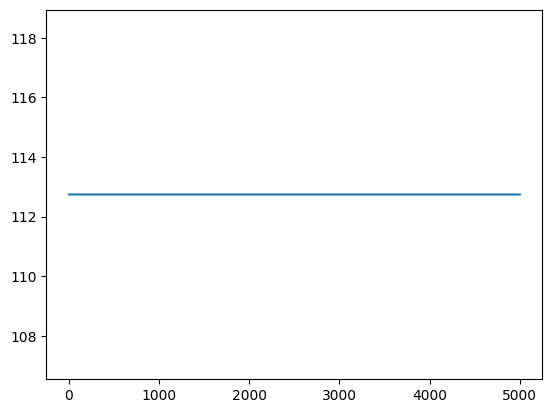

In [101]:
ts = np.linspace(0, 5 * 1e3, 10000)
N_monomers = 128
b = .94  # LJ
zeta = 1  # LJ
tau_1 = N_monomers ** 2 * b ** 2 * zeta / (3 * np.pi ** 2)

plt.plot(ts, rouse_R_sq_avg(ts, p_max=N_monomers, N=N_monomers, b=b, tau_1=tau_1))

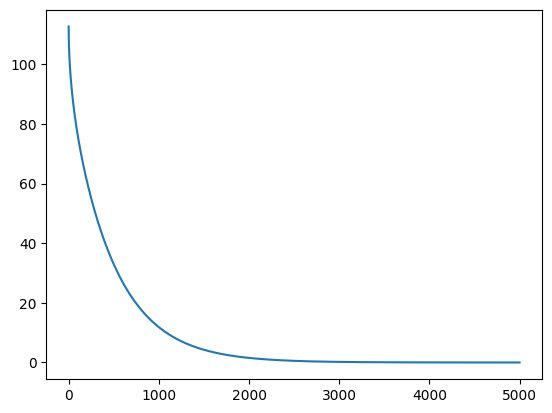

In [102]:
plt.plot(ts, rouse_R_autocorr(ts, p_max=N_monomers, N=N_monomers, b=b, tau_1=tau_1))

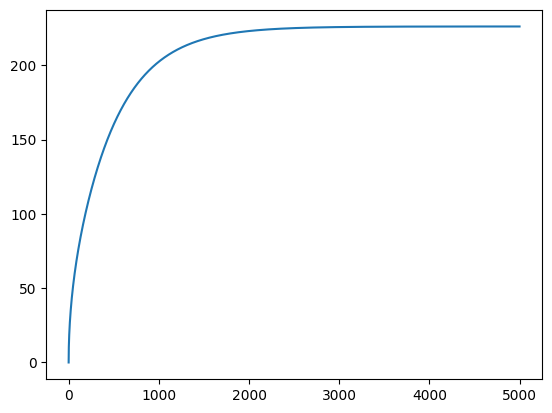

In [108]:
plt.plot(ts, rouse_g_4(ts, p_max=5000, N=N_monomers, tau_1=tau_1, b=b))

In [110]:
3*np.pi**2/24

1.2337005501361697